<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 4: Linear Regression and k-Nearest Neighbours</h2>
<br>

This notebook shows how you can use the k-Nearest Neighbours method in Python. We also use this method to discuss and illustrate important concepts such as overfitting. 

<a href="#1.-Credit-Card-Data">Credit Card Data</a> <br>
<a href="#2.-Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Linear-Regression">Linear Regression</a> <br>
<a href="#4.-K-Nearest-Neighbours">K-Nearest Neighbours</a> <br>
<a href="#5.-Outstanding-Issues">Outstanding Issues</a> <br>
<a href="#6.-Model-Evaluation">Model Evaluation</a> <br>
<a href="#7.-Exercises">Exercises</a> <br>

This notebook relies on the following imports and settings. 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. Credit Card Data

In this lesson we continue working with the `Credit` dataset. At the end of the previous notebook, we saved the training and test dataframes into an HDF5 file. We now use the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_hdf.html" target="_blank"><TT>read_hdf</TT></a> function to load them back into memory.

In [4]:
# We will always assume that the data file is in a subdirectory called "Data"
train=pd.read_hdf('Data/Credit.h5', 'train')
test=pd.read_hdf('Data/Credit.h5', 'test')
train.head(10) 

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,
400,18.701,5524,5,64,7,0,0,966,0,0,1
26,14.090,4323,5,25,16,0,1,671,0,0,0
280,54.319,3063,3,59,8,1,0,269,0,1,0
261,67.937,5184,4,63,12,0,1,345,1,0,1
131,23.793,3821,4,56,12,1,1,868,0,0,0
381,115.123,7760,3,83,14,0,0,661,0,0,0
361,53.566,5891,4,82,10,0,0,712,0,1,0
21,17.700,2860,4,63,16,0,0,89,0,0,1
193,28.508,3933,4,56,14,0,1,336,1,0,1


This following part is identical to the previous notebook.

In [5]:
# Response label
response = 'Balance'

# Creates a list with the names of all variables which are not the respose
predictors =  [variable for variable in train.columns if variable!=response] 

# Response vector and design matrix
y_train = train[response].to_numpy() 
X_train = train[predictors].to_numpy() 

y_test = test[response].to_numpy()
X_test = test[predictors].to_numpy() 

### 2. Exploratory Data Analysis

In the previous notebook, we conducted a basic exploratory data analysis of this dataset. To motivate our work in this tutorial, let's quickly revisit this stage of the analysis. 

Below, we build exploratory plots for the bivariate relatioship betwen the credit card balance and two separate predictors, the credit card limit and the customer income. However, this time we also add (simple) regression lines to the plots to assist with the visualisation. 

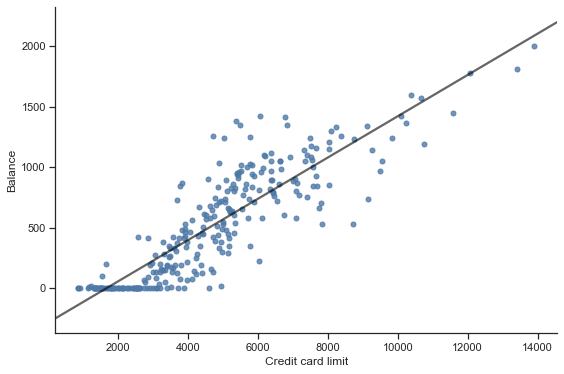

In [6]:
fig, ax = plt.subplots()
sns.regplot(train['Limit'], train['Balance'], ci=None, scatter_kws={'s':25}, 
            line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
sns.despine()
plt.show()

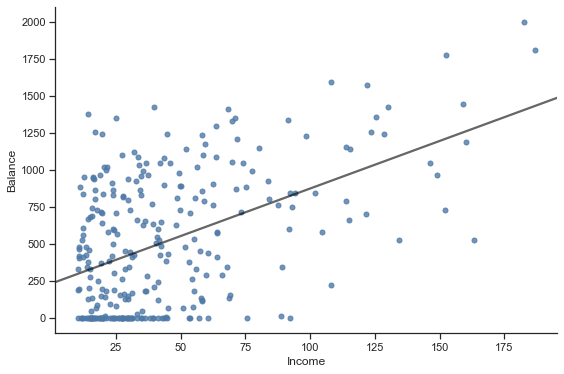

In [7]:
fig, ax = plt.subplots()
sns.regplot(train['Income'], train['Balance'], ci=None, scatter_kws={'s':25}, 
            line_kws={'color':'black', 'alpha':0.6})
ax.set_xlabel('Income')
ax.set_ylabel('Balance')
sns.despine()
plt.show()

These plots suggests that a linear model may not be best approach for this data. The first figure indicates that limit (the predictor with largest correlation with the response) has a nonlinear relationship with the response. In the case of income, linearity may be a better approximation, except for the cluster of customers with zero balance. The lower bound on the response is actually inconsistent with the classic linear regression model. 

While the EDA helps us to build better models, it's important not to draw strong conclusions from it; we are ultimately interested in the relationship between the response and all the predictors jointly. We therefore turn to modelling. 

### 3. Linear Regression

Picking up from where we left in the previous notebook, we recompute the OLS estimators, as well as the fitted values and the residuals for further analysis.

In [8]:
ols = LinearRegression()
ols.fit(X_train, y_train)

y_fitted = ols.predict(X_train)
resid = y_train - y_fitted

Diagnostic plots confirm that the linear regression model is unable to entirely describe the relationship between the response and the predictors. In particular, we note that it inconsistently generates negative fitted values, and that there is a nonlinear relationship between limit and the residuals. 

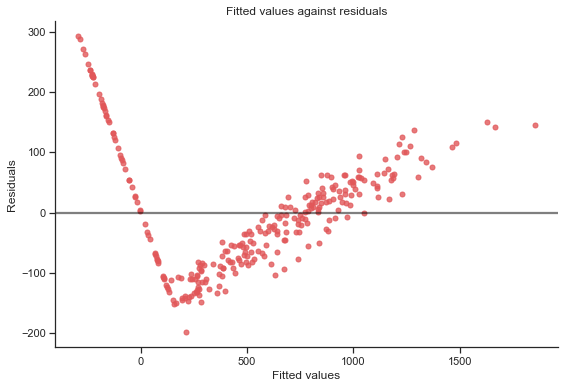

In [9]:
fig, ax = plt.subplots()
sns.regplot(y_fitted, resid, ci=None, scatter_kws={'s':25, 'color':crayon[2]}, 
            line_kws={'color':'black', 'alpha':0.5})
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Fitted values against residuals')
sns.despine()
plt.show()

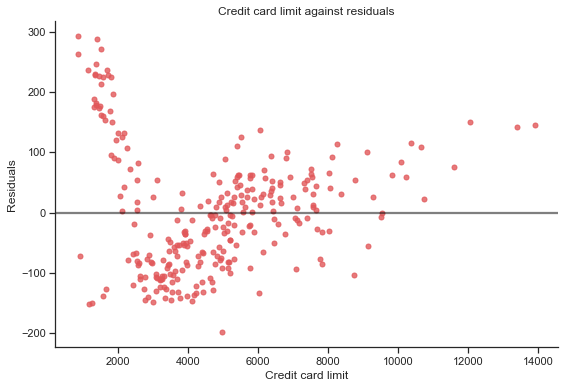

In [10]:
fig, ax = plt.subplots()
sns.regplot(train['Limit'], resid, ci=None,  scatter_kws={'s':25, 'color':crayon[2]},
            line_kws={'color':'black', 'alpha':0.5})
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Residuals')
ax.set_title('Credit card limit against residuals')
sns.despine()
plt.show()

### 4. k-Nearest Neighbours

 The <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html" target="_blank"><TT>k-Nearest Neighbours</TT></a> (kNN) method is a flexible algorithm that can approximate complex relationships between the response and predictors without assuming a particular form for the regression function.
    
Using the kNN method with scikit-learn follows the template described in the previous tutorial. Unlike in the linear regression model, however, we need to specify a hyperparameter (the number of neighbours) when instantiating the model. Scikit-learns uses the Euclidean distance by default. 

In [11]:
# This cell is for illustrative purposes only! 
# We should scale the predictors when using the Euclidean distance and p>1
# However, we won't need this here because our distance metric will automatically do the scaling later

from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10) # we should specify the number of neighbours
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

**4.1 How does changing $k$ affect the fit?**

In this section we focus on a single predictor, the credit card limit, to illustrate how the fit changes according to the number of neighbours. Below, we plot the fit with 2, 10, and 50 neighbours. Choosing k=2 clearly overfits the data, while k=50 underfits part of the data.  

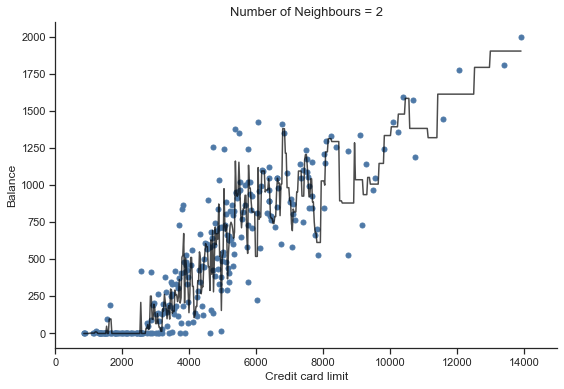

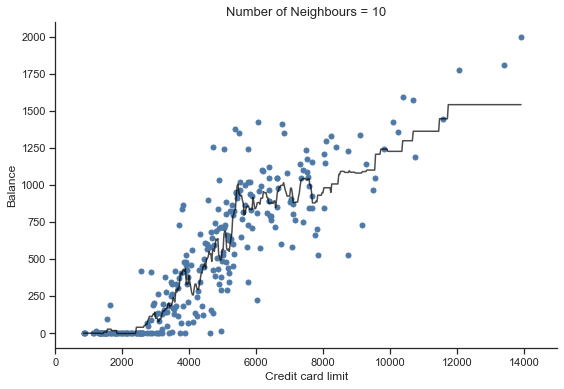

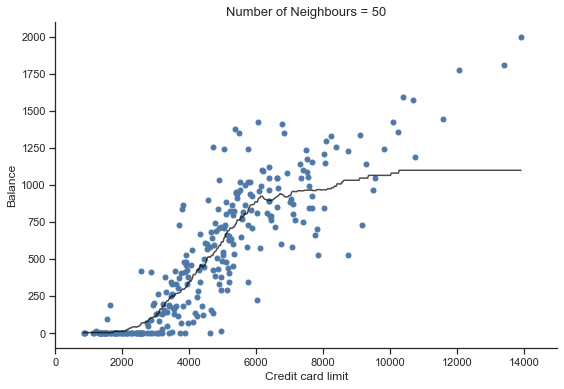

In [12]:
for k in [2, 10, 50]:
    
    # Fit the model
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train[['Limit']], y_train)

    # Generate a grid of 500 values ranging from the minimum to the maximum value of the variable 
    # in the training data
    x = np.linspace(train['Limit'].min(),train['Limit'].max(), 500).reshape((-1,1))

    # Compute the predicted values for each of these input points
    y_fitted = knn.predict(x)

    # Plot figure
    fig, ax = plt.subplots()
    ax.scatter(train[['Limit']], y_train, s=25) # the s option is the size of the dot
    ax.set_xlabel('Credit card limit')
    ax.set_ylabel('Balance')
    ax.set_xlim(0, 15000)
    ax.plot(x, y_fitted, color='black', alpha = 0.7)
    ax.set_title(f'Number of Neighbours = {k}', fontsize=13)
    sns.despine()
    plt.show()

**4.2 Alternative Specifications**

Let's now consider some specifications to test against the linear regression benchmark. Recall in the the kNN method, we need to choose the number of neighbours and the distance metric, as well as the predictors.

For now, we arbitrarily set the number of neighbours to five. We choose the Mahalanobis metric for the distance function, since it tends to work better for the Euclidean distance when there are multiple predictors.

In case of the predictors, the kNN method has first major limitations that we should keep in mind. The first is the curse of dimensionality, of course. The performance of kNN in particularly sensitive to the presence of irrelevant or weak predictors.  The second is that kNN not handle mixed data types well, since the distance metric does not naturally compare variables of different types.

We theferore consider three variations. The first only includes income and limit, which we can both regard as continuous variables, and are the two predictors with highest correlation with the response. The second also includes the dummy variable for student, which has the third largest correlation.  The last specification includes all the predictors.  

In [13]:
subset1 = ['Income', 'Limit']
subset2 = ['Income', 'Limit', 'Student']
subset3 = predictors

# Two predictors
knn1 = KNeighborsRegressor(n_neighbors = 5, metric='mahalanobis', 
                          metric_params={'V': np.cov(train[subset1], rowvar=False)}) 
knn1.fit(train[subset1], y_train)

# Three predictors
knn2 = KNeighborsRegressor(n_neighbors = 5, metric='mahalanobis', 
                          metric_params={'V': np.cov(train[subset2], rowvar=False)}) 
knn2.fit(train[subset2], y_train)

# All predictors
knn3 = KNeighborsRegressor(n_neighbors = 5, metric='mahalanobis', 
                          metric_params={'V': np.cov(train[subset3], rowvar=False)}) 
knn3.fit(train[subset3], y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V': array([[ 1.21019e+03,  6.49996e+04, ...,  5.30897e-01, -1.19929e+00],
       [ 6.49996e+04,  5.49270e+06, ...,  2.91168e+01, -8.19004e+01],
       ...,
       [ 5.30897e-01,  2.91168e+01, ...,  2.50883e-01, -1.22734e-01],
       [-1.19929e+00, -8.19004e+01, ..., -1.22734e-01,  1.84537e-01]])},
          n_jobs=None, n_neighbors=5, p=2, weights='uniform')

### 5. Outstanding Issues

Before proceeding to model evaluation, it's important to highlight that we are still working with a restricted set of tools. Therefore, our analysis so far has major limitations: we have chosen the number of neighbours and the predictor variables arbitrarily, and made no attempt to identify the most promising algorithm using the training data. 

We'll address these issues in the coming weeks.

### 6. Model Evaluation

The code to compute the test results is a bit more involved than last time because we are now working with multiple models, each based on a different subset of predictors. Make sure that you understand what `enumerate` and `zip` do in the loop (the latter is new for us). 

As anticipated, kNN predicts poorly when we use all the predictors because of the curse of dimensionality. However, with three predictors, there is a small improvement over the linear regression model. 

In [14]:
# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Linear Regression', 'kNN (two predictors)', 'kNN (three predictors)', 'kNN (all predictors)']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, knn1, knn2, knn3] 
subsets = [predictors, subset1, subset2, subset3]

# Computer test predictions and metrics
for i, (method, subset) in enumerate(zip(methods, subsets)):
    y_pred = method.predict(test[subset])
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred)

results.round(2)

,RMSE,R-Squared,MAE
Linear Regression,97.19,0.96,80.03
kNN (two predictors),170.72,0.86,105.91
kNN (three predictors),91.82,0.96,52.50
kNN (all predictors),268.36,0.66,202.72


We could improve the performance of the linear regression model by setting the negative predictions to zero (since we know that the credit card balance cannot be negative), and the performance of the kNN method by systematically selecting the number of neighbours. 

### 7. Exercises

Complete the following code to generate a plot of the test performance for the kNN model as we change the number of neighbours. Work with your favourite specification.

In [ ]:
ks = np.arange(1, 101)

rmses = []
for k in ks: 
    # 1. Specify and fit the model on the training data (there is no need to store it)
    # 2. Compute predictions for the test data
    # 3. Compute the root mean squared error and assign to a variable called rmse
    rmses.append(rmse)
    
fig, ax= plt.subplots()
ax.plot(values, rmses)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Test RMSE')
plt.show()

The following code will give you the value of $k$ with lowest test error (why?).

In [ ]:
1 + np.argmin(rmses)

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [16]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [17]:
from IPython.core.display import HTML
style = open('css\jupyter.css', "r").read()
HTML('<style>'+ style +'</style>')